# consistency of self calls
We are trying to see how reliably self echoes are heard and how consistent they are in the information they provide as oppposed to information coming from other direct calls/ echeos from their direct calls

Let us first load the data. 

In [1]:
import sys
import os 
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import itertools
import pickle
os.chdir("/home/adityamoger/Documents/GitHub/dynamic_model_of_cocktail_party_nightmare/")

sys.path.append("./exploratory_analysis/")
sys.path.append("./dynamic_model/")
from snr_implementation import given_sound_objects_return_detected_sounds


from read_simulation_output import read_data_per_simulation_per_bat
from snr_implementation import given_sound_objects_return_detected_sounds
from supporting_files.utilities import make_dir

import bisect
plt.style.use("dark_background")

In [2]:
def make_ordered_lists_of_params(array_of_parameter_lists):
    product_of_lists = list(itertools.product(*array_of_parameter_lists))
    return product_of_lists

def reformat_matrices(nan_matrix, track_unique_objects):
    
    nan_matrix = nan_matrix.T
    
    sorting_indices = np.argsort(track_unique_objects)
    nan_matrix = nan_matrix[sorting_indices]
    track_unique_objects = np.array(track_unique_objects)[sorting_indices]
    
    # nan_matrix = nan_matrix[:, ~np.isnan(nan_matrix).all(0)]
    masked_array = np.ma.array(nan_matrix, mask=np.isnan(nan_matrix))
    
    return nan_matrix, track_unique_objects, masked_array

In [3]:
NUM_BATS = 30
TEMPORAL_MASKING_DIR = "./exploratory_analysis/temporal_masking_fn.csv"
DIRECTORY = f"/media/adityamoger/T7 Shield/consistency_of_calls/DATA_effect_of_group_size/{NUM_BATS}/iteration_number_3/"
DIRECTORY_STORE_PLOTS = "./exploratory_analysis/plots/"

In [4]:
#store extracted data into a dict
# key needs to be some structure such that the parameters for that can be extracted. maybe ill just make it ordered

INCLUDE_DIRECT_SOUNDS_ARR = [True]
FOCAL_BATS = [1, 7, 17]
AZIMUTH_THRESHOLDS = [np.pi,np.pi/2,np.pi/6]

list_of_parameters = [FOCAL_BATS, INCLUDE_DIRECT_SOUNDS_ARR, AZIMUTH_THRESHOLDS]
ordered_list_of_parameters = make_ordered_lists_of_params(list_of_parameters)
labels_of_parameters = ["focal_bat", "include_direct_sounds", "azimuth_thresholds"]

In [5]:
# dictionary_to_store_all_sounds = {}
# dictionary_to_store_heard_sounds = {}
# #keys of dictionary will be  the ordered param lists

# for param in ordered_list_of_parameters:
#     FOCAL_BAT, INCLUDE_DIRECT_SOUNDS, AZIMUTH  = param
#     track_unique_objects = []
#     sounds_to_plot = []
#     times_of_sounds_to_plot = []
#     delta_t = []
#     OUTPUT_DIR = DIRECTORY + f"/{FOCAL_BAT}/"
#     received_sounds_sorted_by_time = read_data_per_simulation_per_bat(
#         OUTPUT_DIR, "received"
#     )
#     if len(received_sounds_sorted_by_time)==0:
#         raise ValueError("empty dir")
    
    
#     cm = plt.get_cmap("gist_rainbow")


#     nan_matrix = (
#         np.zeros(
#             shape=(len(received_sounds_sorted_by_time), NUM_BATS - 1 + 4)
#         )
#         * np.nan
#     )
#     list_of_heard_sounds = []
#     for i, frame in enumerate(received_sounds_sorted_by_time):
#         heard_sounds = given_sound_objects_return_detected_sounds(
#             sound_objects=frame,
#             time_threshold_post_call=0.035,
#             angle_threshold=AZIMUTH,
#             dir_of_temporal_masking_fn_file=TEMPORAL_MASKING_DIR,
#             minimum_sound_detection_fraction=0.75,
#             focal_bat=FOCAL_BAT,
#             include_direct_sounds=INCLUDE_DIRECT_SOUNDS,
#         )
# #         list_of_heard_sounds.append(heard_sounds)
#     dictionary_to_store_heard_sounds[param] = list_of_heard_sounds
#     dictionary_to_store_all_sounds[param] = received_sounds_sorted_by_time
#     print(param)


In [6]:
import pickle
# with open(f'/media/adityamoger/T7 Shield/consistency_of_calls/DATA_effect_of_group_size/{NUM_BATS}/heard_sounds_data.pkl', 'wb') as fp:
#     pickle.dump(dictionary_to_store_heard_sounds, fp)
# with open(f'/media/adityamoger/T7 Shield/consistency_of_calls/DATA_effect_of_group_size/{NUM_BATS}/all_sounds_data.pkl', 'wb') as fp:
#     pickle.dump(dictionary_to_store_all_sounds, fp)

In [7]:
with open(f'/media/adityamoger/T7 Shield1/consistency_of_calls/DATA_effect_of_group_size/{NUM_BATS}/180_90_30_1_7_17_data/heard_sounds_data.pkl', 'rb') as fp:
    dictionary_to_store_heard_sounds = pickle.load(fp)
# with open(f'/media/adityamoger/T7 Shield/consistency_of_calls/DATA_effect_of_group_size/{NUM_BATS}/180_90_30_1_7_17_data/all_sounds_data.pkl', 'rb') as fp:
#     dictionary_to_store_all_sounds = pickle.load(fp)

lets plot consistency of self calls. 
the labels are sorted by dictionary ordering. 

In [8]:
INCLUDE_DIRECT_SOUNDS_ARR = [True]
FOCAL_BATS = [1,7]
AZIMUTH_THRESHOLDS = [np.pi, np.pi/2]

list_of_parameters_sublist = [FOCAL_BATS, INCLUDE_DIRECT_SOUNDS_ARR, AZIMUTH_THRESHOLDS]
ordered_list_of_parameters_sublist = make_ordered_lists_of_params(list_of_parameters_sublist)
# labels_of_parameters = ["focal_bat", "include_direct_sounds", "azimuth_thresholds"]
print(ordered_list_of_parameters_sublist)

[(1, True, 3.141592653589793), (1, True, 1.5707963267948966), (7, True, 3.141592653589793), (7, True, 1.5707963267948966)]


In [9]:
%matplotlib inline
store_matrices_given_param_theta = []
store_unique_objects_theta = []
store_masked_array_theta = []
for param in ordered_list_of_parameters_sublist:
    FOCAL_BAT, INCLUDE_DIRECT_SOUNDS, AZIMUTH  = param
    track_unique_objects = []

    heard_sounds_array = dictionary_to_store_heard_sounds[param]
    
    nan_matrix_theta_self_echoes = (
        np.zeros(
            shape=(len(heard_sounds_array), NUM_BATS - 1 + 4)
        )
        * np.nan
    )
    nan_matrix_theta_direct = (
        np.zeros(
            shape=(len(heard_sounds_array), NUM_BATS - 1 + 4)
        )
        * np.nan
    )
    nan_matrix_theta_non_self_echoes = (
        np.zeros(
            shape=(len(heard_sounds_array), NUM_BATS - 1 + 4)
        )
        * np.nan
    )
    
    for i, frame_heard_sounds in enumerate(heard_sounds_array):
        
        for sound_object in frame_heard_sounds:

            time = (
                np.array(sound_object["occurance_times"])[0]
                - sound_object["bat_last_call_time"]
                + i * 0.04
            )
            theta = sound_object["bat_direction"].angle_between(
                sound_object["incident_direction"]
            )

            if sound_object["emitter_id"] == FOCAL_BAT:
                reflected_from = sound_object["reflected_from"]
                if reflected_from not in track_unique_objects:
                    track_unique_objects.append(reflected_from)
                index = track_unique_objects.index(reflected_from)
                
                nan_matrix_theta_self_echoes[i, index] = theta
                
            elif sound_object["emitter_id"] != FOCAL_BAT and sound_object["type"] == "echo":
                reflected_from = sound_object["reflected_from"]
                if reflected_from not in track_unique_objects:
                    track_unique_objects.append(reflected_from)
                index = track_unique_objects.index(reflected_from)
                # print(track_unique_objects)
                nan_matrix_theta_non_self_echoes[i, index] = theta
            
            elif sound_object["emitter_id"] != FOCAL_BAT and sound_object["type"] == "direct":
                emitter = f"bat_{sound_object["emitter_id"]}"
                if emitter not in track_unique_objects:
                    track_unique_objects.append(emitter)
                index = track_unique_objects.index(emitter)
                
                nan_matrix_theta_direct[i, index] = theta
        
    nan_matrix_theta_direct, unique_direct, masked_array_direct= reformat_matrices(nan_matrix_theta_direct, track_unique_objects)
    nan_matrix_theta_self_echoes, unique_self_echoes_from, masked_array_self_echoes = reformat_matrices(nan_matrix_theta_self_echoes, track_unique_objects)  
    nan_matrix_theta_non_self_echoes, unique_non_self_echoes_from, masked_array_non_self_echoes = reformat_matrices(nan_matrix_theta_non_self_echoes, track_unique_objects)
    
    store_matrices_given_param_theta.append([nan_matrix_theta_self_echoes, nan_matrix_theta_direct, nan_matrix_theta_non_self_echoes])
    store_unique_objects_theta.append(unique_self_echoes_from)
    store_masked_array_theta.append([masked_array_self_echoes, masked_array_direct, masked_array_non_self_echoes])
    

In [10]:
store_matrices_given_param_delta_t = []
store_unique_objects_delta_t = []
store_masked_array_delta_t = []
for param in ordered_list_of_parameters_sublist:
    FOCAL_BAT, INCLUDE_DIRECT_SOUNDS, AZIMUTH  = param
    track_unique_objects = []

    heard_sounds_array = dictionary_to_store_heard_sounds[param]
    
    nan_matrix_delta_t_self_echoes = (
        np.zeros(
            shape=(len(heard_sounds_array), NUM_BATS - 1 + 4)
        )
        * np.nan
    )
    nan_matrix_delta_t_direct = (
        np.zeros(
            shape=(len(heard_sounds_array), NUM_BATS - 1 + 4)
        )
        * np.nan
    )
    nan_matrix_delta_t_non_self_echoes = (
        np.zeros(
            shape=(len(heard_sounds_array), NUM_BATS - 1 + 4)
        )
        * np.nan
    )
    
    for i, frame_heard_sounds in enumerate(heard_sounds_array):
        
        for sound_object in frame_heard_sounds:

            delta_t = np.array(sound_object["occurance_times"])[0] - sound_object["bat_last_call_time"]

            if sound_object["emitter_id"] == FOCAL_BAT:
                reflected_from = sound_object["reflected_from"]
                if reflected_from not in track_unique_objects:
                    track_unique_objects.append(reflected_from)
                index = track_unique_objects.index(reflected_from)
                
                nan_matrix_delta_t_self_echoes[i, index] = delta_t
                
            elif sound_object["emitter_id"] != FOCAL_BAT and sound_object["type"] == "echo":
                reflected_from = sound_object["reflected_from"]
                if reflected_from not in track_unique_objects:
                    track_unique_objects.append(reflected_from)
                index = track_unique_objects.index(reflected_from)
                # print(track_unique_objects)
                nan_matrix_delta_t_non_self_echoes[i, index] = delta_t
            
            elif sound_object["emitter_id"] != FOCAL_BAT and sound_object["type"] == "direct":
                emitter = f"bat_{sound_object["emitter_id"]}"
                if emitter not in track_unique_objects:
                    track_unique_objects.append(emitter)
                index = track_unique_objects.index(emitter)
                
                nan_matrix_delta_t_direct[i, index] = delta_t
        
    nan_matrix_delta_t_direct, unique_direct, masked_array_direct= reformat_matrices(nan_matrix_delta_t_direct, track_unique_objects)
    nan_matrix_delta_t_self_echoes, unique_self_echoes_from, masked_array_self_echoes = reformat_matrices(nan_matrix_delta_t_self_echoes, track_unique_objects)  
    nan_matrix_delta_t_non_self_echoes, unique_non_self_echoes_from, masked_array_non_self_echoes = reformat_matrices(nan_matrix_delta_t_non_self_echoes, track_unique_objects)
    
    store_matrices_given_param_delta_t.append([nan_matrix_delta_t_self_echoes, nan_matrix_delta_t_direct, nan_matrix_delta_t_non_self_echoes])
    store_unique_objects_delta_t.append(unique_self_echoes_from)
    store_masked_array_delta_t.append([masked_array_self_echoes, masked_array_direct, masked_array_non_self_echoes])
    

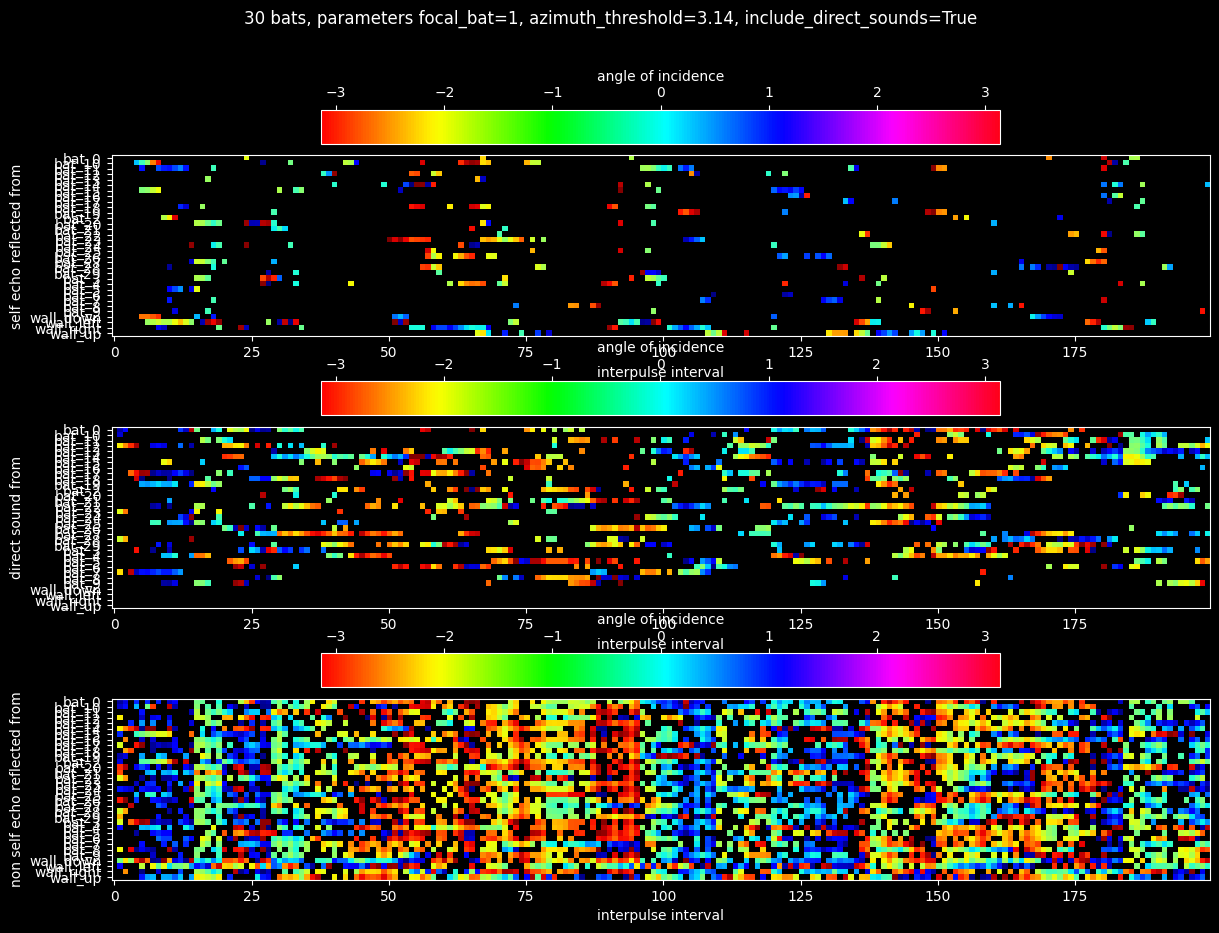

<Figure size 640x480 with 0 Axes>

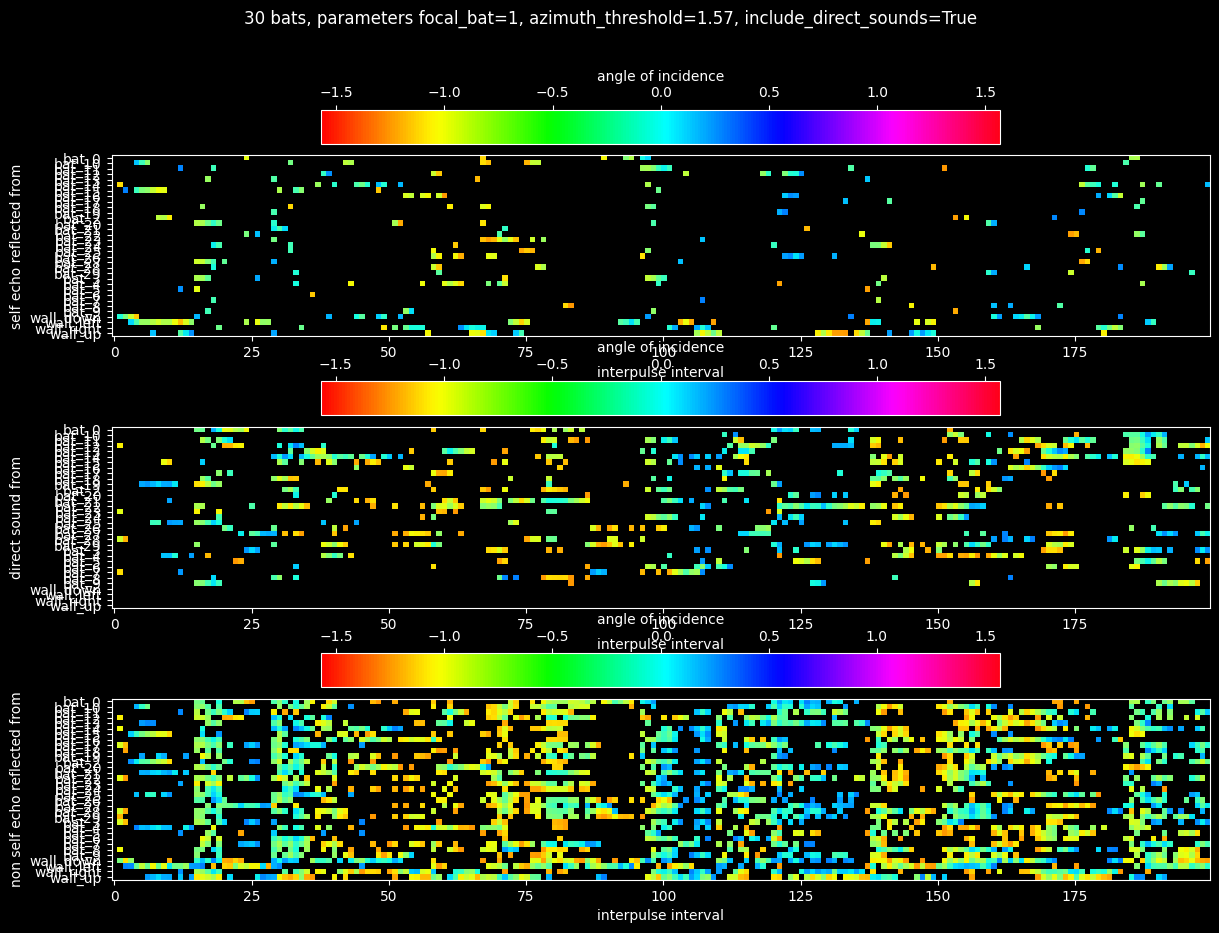

<Figure size 640x480 with 0 Axes>

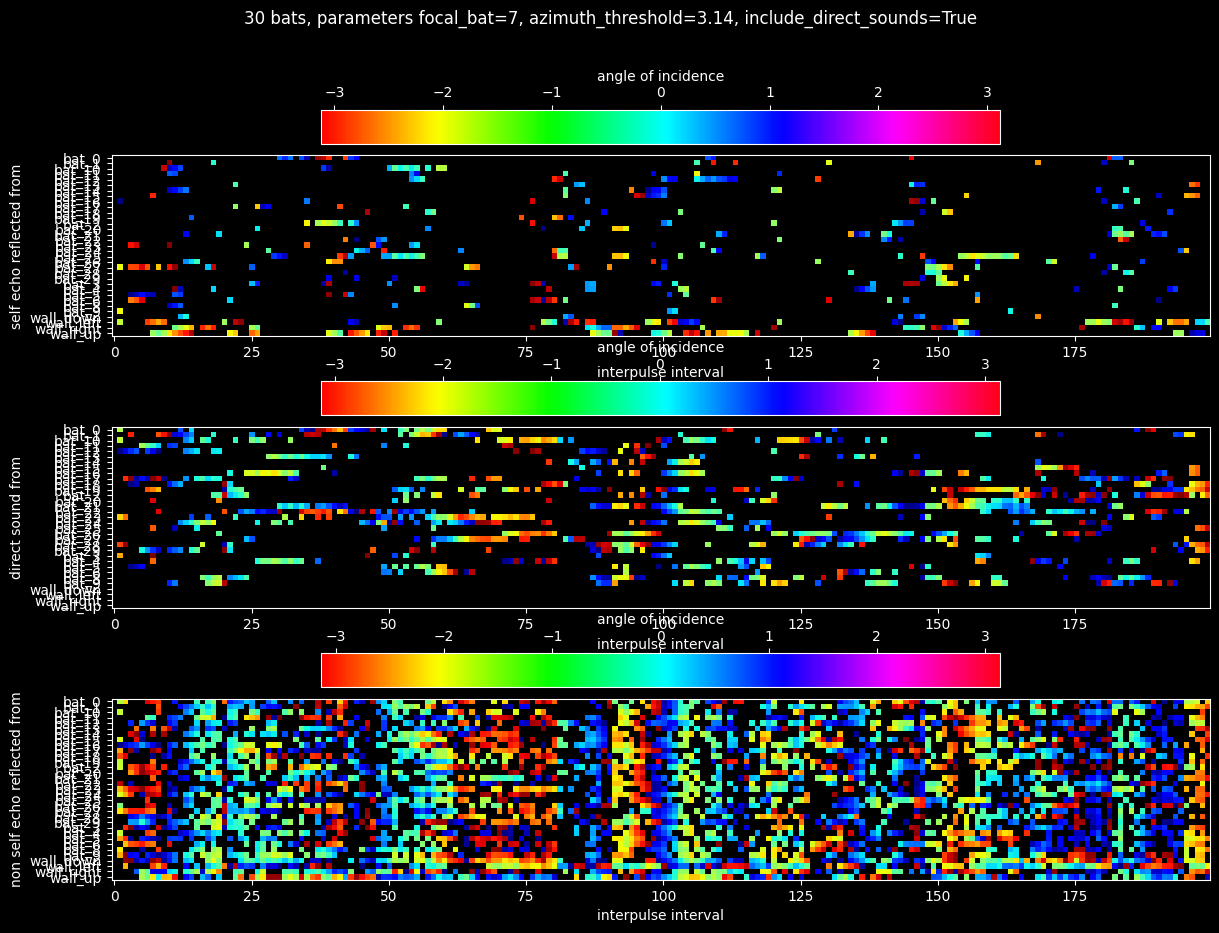

<Figure size 640x480 with 0 Axes>

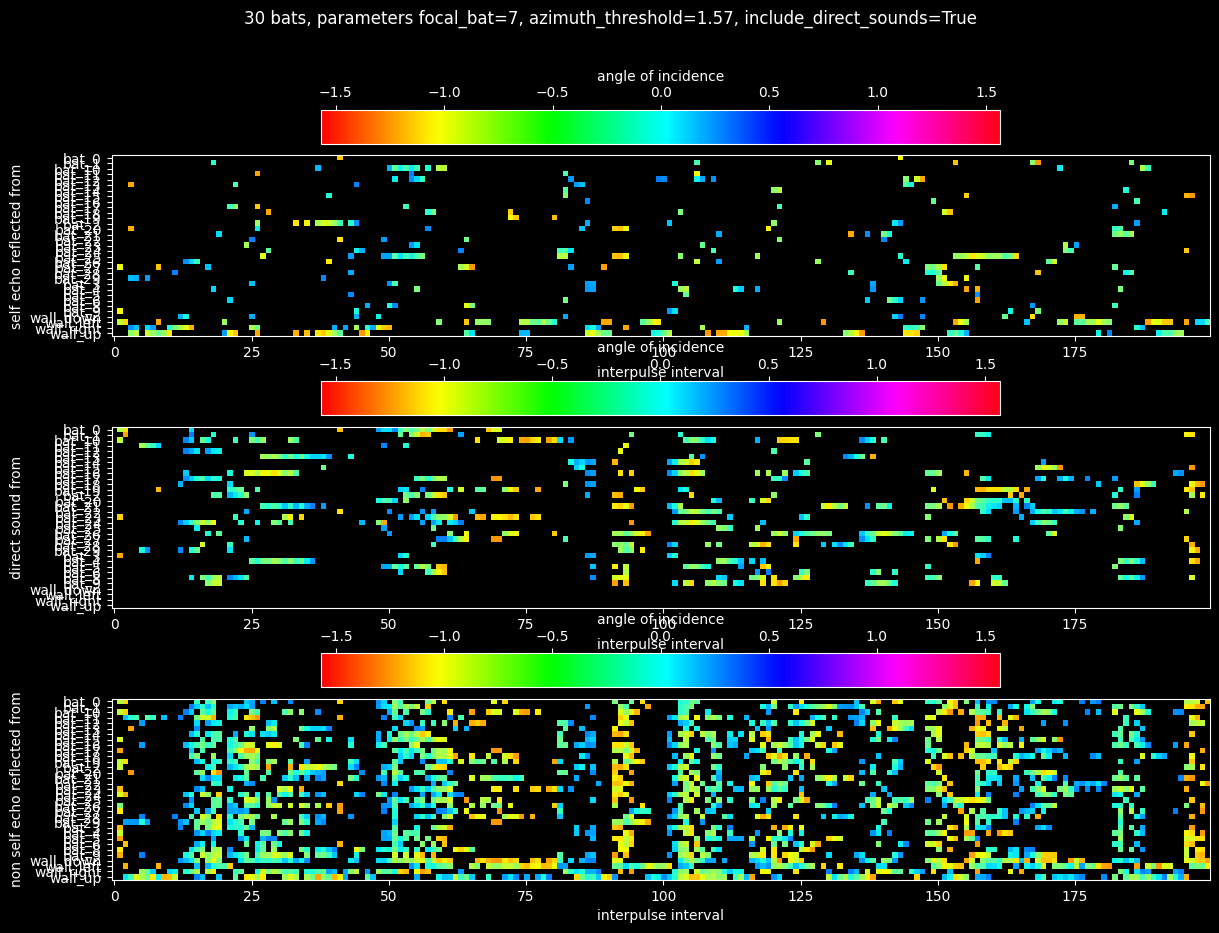

<Figure size 640x480 with 0 Axes>

In [11]:
for i, param in enumerate(ordered_list_of_parameters_sublist):
    FOCAL_BAT, INCLUDE_DIRECT_SOUNDS, AZIMUTH  = param
    
    list_of_matrices = store_matrices_given_param_theta[i]
    track_unique_objects = store_unique_objects_theta[i]
    masked_arrays_given_param = store_masked_array_theta[i]
    
    cmap_masked = mpl.cm.jet
    cmap_masked.set_bad('black',1.)
    
    
    plt.figure(figsize=(40, 10))
    plt.subplot(3,1,1)
    plt.imshow(list_of_matrices[0], cmap=mpl.colormaps["hsv"])
    plt.colorbar(
        location="top",
        label="angle of incidence",
    )
    plt.ylabel("self echo reflected from")
    plt.xlabel("interpulse interval")
    plt.yticks(
        labels=track_unique_objects, ticks=np.arange(0, list_of_matrices[0].shape[0])
    )
    plt.imshow(masked_arrays_given_param[0], interpolation='nearest', cmap=cmap_masked)
    plt.clim(-np.pi, np.pi)
    
    plt.subplot(3,1,2)
    plt.imshow(list_of_matrices[1], cmap=mpl.colormaps["hsv"])
    plt.colorbar(
        location="top",
        label="angle of incidence",
    )
    plt.ylabel("direct sound from")
    plt.xlabel("interpulse interval")
    plt.yticks(
        labels=track_unique_objects, ticks=np.arange(0, list_of_matrices[0].shape[0])
    )
    plt.imshow(masked_arrays_given_param[1], interpolation='nearest', cmap=cmap_masked)
    plt.clim(-np.pi, np.pi)
    
    plt.subplot(3,1,3)
    plt.imshow(list_of_matrices[2], cmap=mpl.colormaps["hsv"])
    plt.colorbar(
        location="top",
        label="angle of incidence",
    )
    plt.ylabel("non self echo reflected from")
    plt.xlabel("interpulse interval")
    plt.yticks(
        labels=track_unique_objects, ticks=np.arange(0, list_of_matrices[0].shape[0])
    )
    plt.imshow(masked_arrays_given_param[2], interpolation='nearest', cmap=cmap_masked)
    plt.clim(-np.pi, np.pi)
    
    plt.suptitle(f"{NUM_BATS} bats, parameters focal_bat={FOCAL_BAT}, azimuth_threshold={np.round(AZIMUTH,2)}, include_direct_sounds={INCLUDE_DIRECT_SOUNDS}")
    plt.show()
    plt.clf()

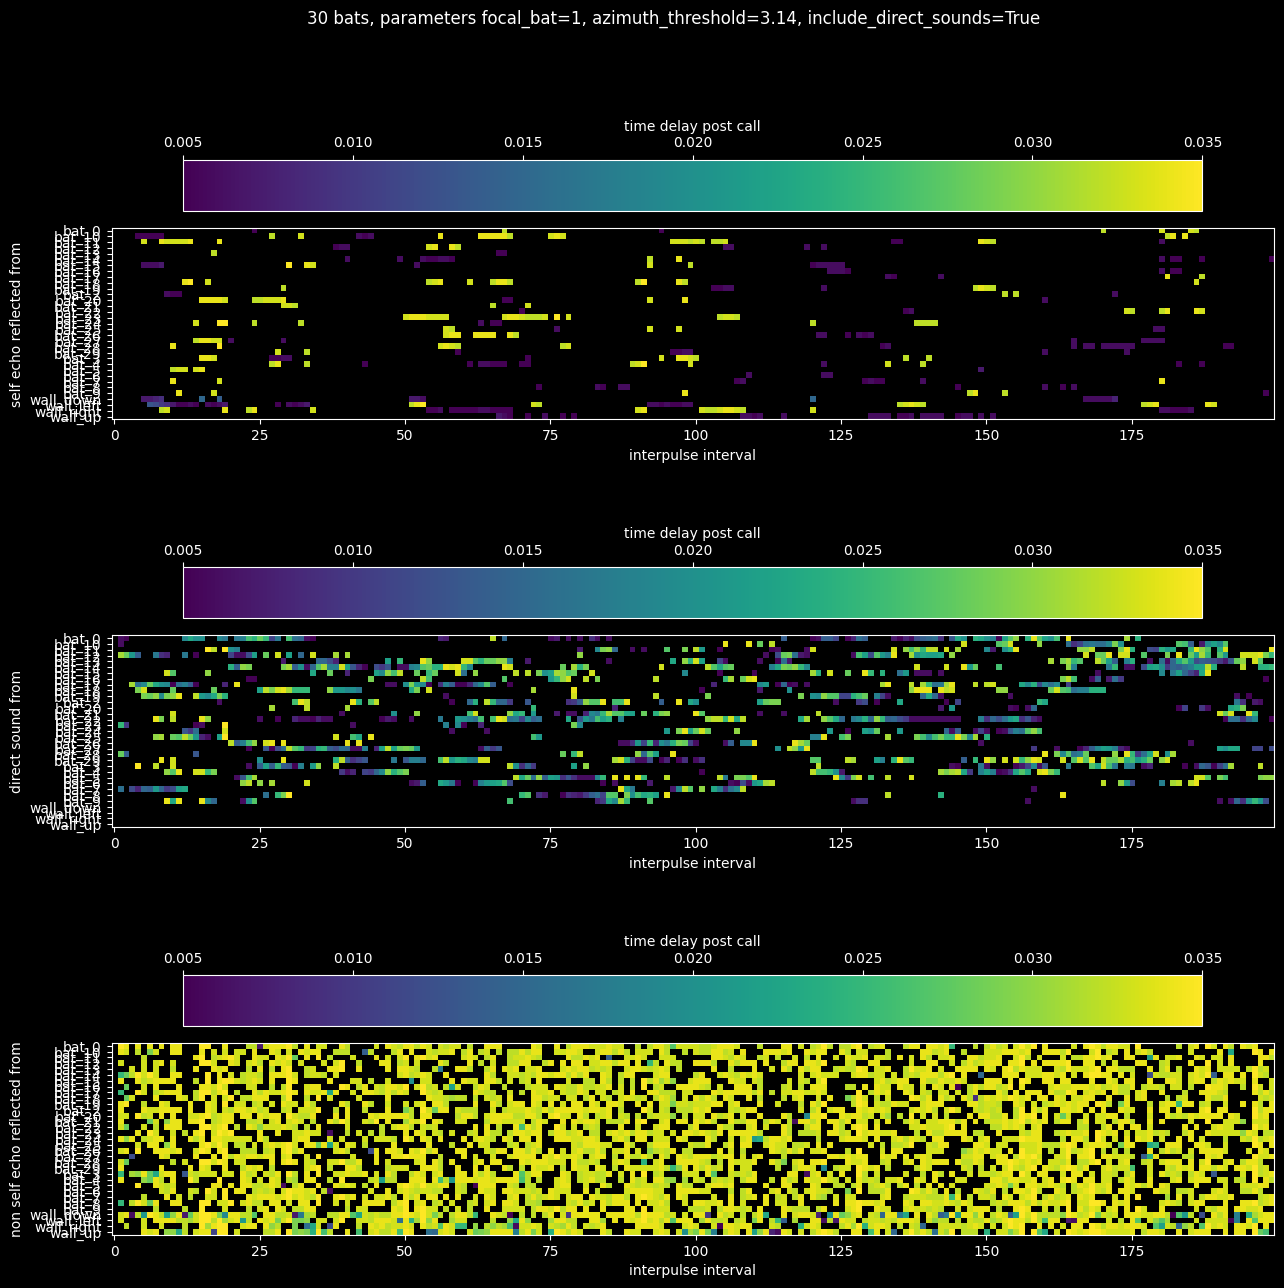

<Figure size 640x480 with 0 Axes>

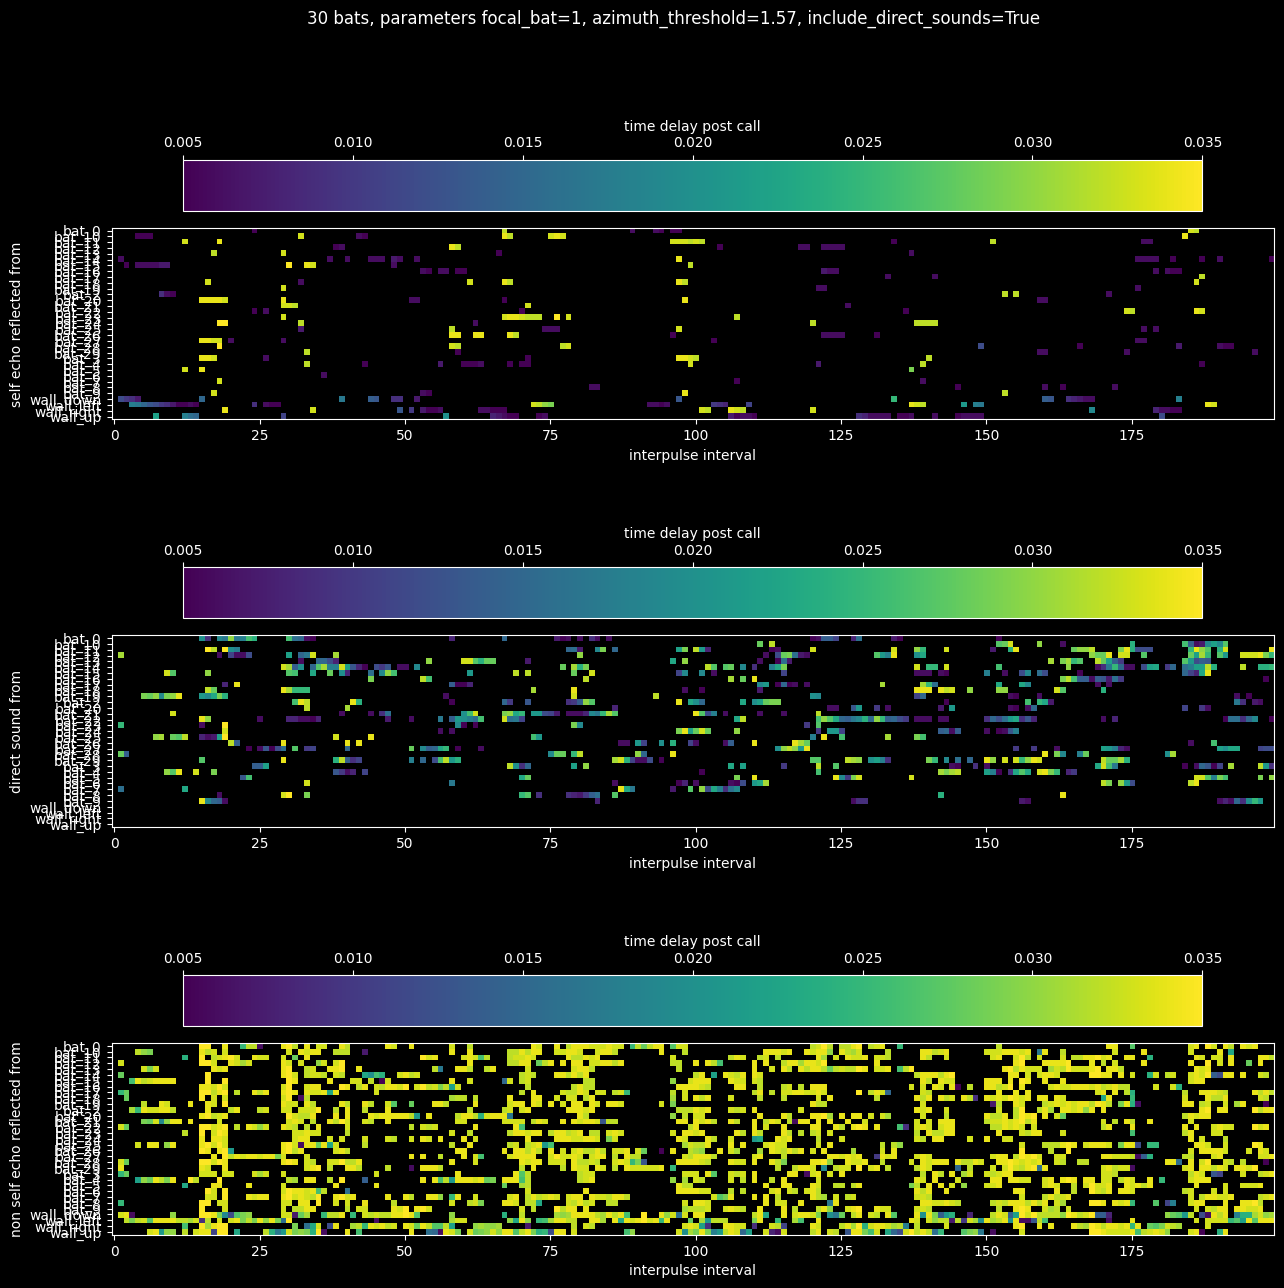

<Figure size 640x480 with 0 Axes>

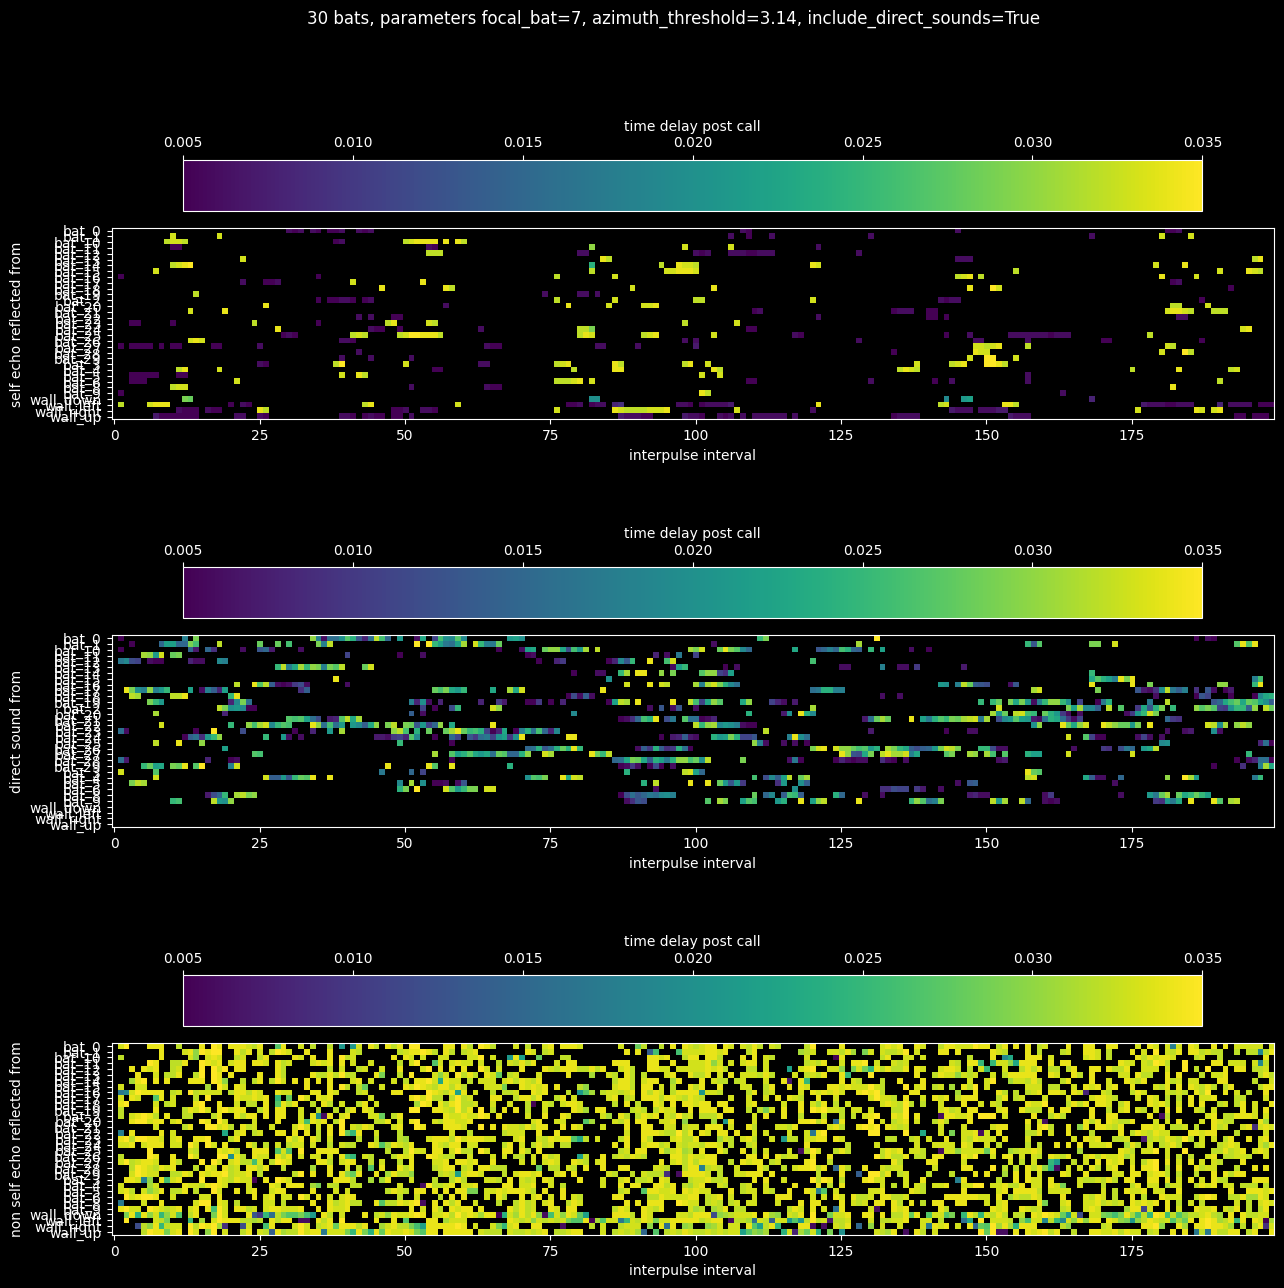

<Figure size 640x480 with 0 Axes>

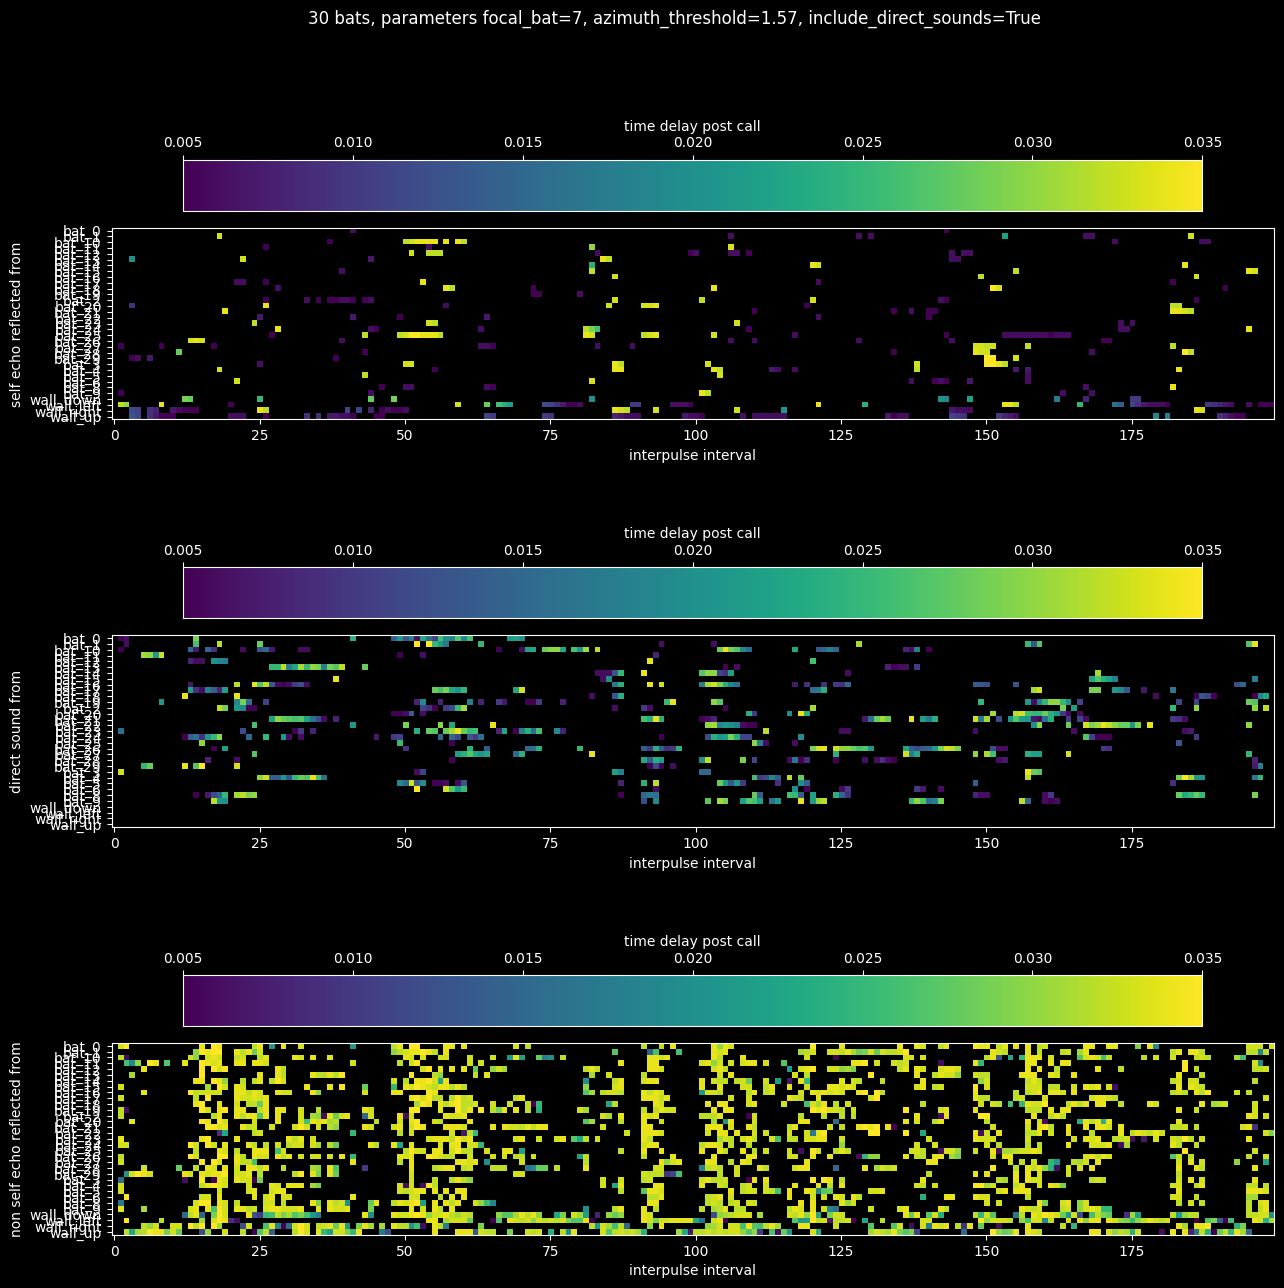

<Figure size 640x480 with 0 Axes>

In [12]:
for i, param in enumerate(ordered_list_of_parameters_sublist):
    FOCAL_BAT, INCLUDE_DIRECT_SOUNDS, AZIMUTH  = param
    
    list_of_matrices = store_matrices_given_param_delta_t[i]
    track_unique_objects = store_unique_objects_delta_t[i]
    masked_arrays_given_param = store_masked_array_delta_t[i]
    
    cmap_masked = mpl.cm.viridis
    cmap_masked.set_bad('black',1.)
    
    
    plt.figure(figsize=(15, 15))
    
    plt.subplot(3,1,1)
    plt.imshow(list_of_matrices[0], cmap = mpl.colormaps["viridis"])
    plt.colorbar(
        location="top",
        label="time delay post call",
    )
    plt.ylabel("self echo reflected from")
    plt.xlabel("interpulse interval")
    plt.yticks(
        labels=track_unique_objects, ticks=np.arange(0, list_of_matrices[0].shape[0])
    )
    plt.imshow(masked_arrays_given_param[0], interpolation='nearest', cmap=cmap_masked)
    plt.clim(0.005,0.035)
    
    plt.subplot(3,1,2)
    plt.imshow(list_of_matrices[1], cmap=mpl.colormaps["viridis"])
    plt.colorbar(
        location="top",
        label="time delay post call",
    )
    plt.ylabel("direct sound from")
    plt.xlabel("interpulse interval")
    plt.yticks(
        labels=track_unique_objects, ticks=np.arange(0, list_of_matrices[0].shape[0])
    )
    plt.imshow(masked_arrays_given_param[1], interpolation='nearest', cmap=cmap_masked)
    plt.clim(0.005,0.035)
    
    plt.subplot(3,1,3)
    plt.imshow(list_of_matrices[2], cmap=mpl.colormaps["viridis"])
    plt.colorbar(
        location="top",
        label="time delay post call",
    )
    plt.ylabel("non self echo reflected from")
    plt.xlabel("interpulse interval")
    plt.yticks(
        labels=track_unique_objects, ticks=np.arange(0, list_of_matrices[0].shape[0])
    )
    plt.imshow(masked_arrays_given_param[2], interpolation='nearest', cmap=cmap_masked)
    plt.clim(0.005,0.035)
    
    plt.suptitle(f"{NUM_BATS} bats, parameters focal_bat={FOCAL_BAT}, azimuth_threshold={np.round(AZIMUTH,2)}, include_direct_sounds={INCLUDE_DIRECT_SOUNDS}")
    # plt.tight_layout()
    plt.show()
    plt.clf()

Lets now make a circular grid to see if things occur consistenly in r and theta 


In [19]:
ANGULAR_RESOLUTION = np.pi/6 # radians
RADIAL_RESOLUTION = 0.002 #in seconds

# spatial_grid_r = np.arange(0.005,0.036,RADIAL_RESOLUTION)
# spatial_grid_theta = np.arange(-np.pi, np.pi, ANGULAR_RESOLUTION)
# matrix_spatial_grid = np.zeros(shape=(len(spatial_grid_r), len(spatial_grid_theta)))

#given time step
given_matrix_delta_t = nan_matrix_delta_t_direct.copy()
given_matrix_theta = nan_matrix_theta_direct.copy()

def convert_into_grids(heard_sounds_array):
    
    grid_labels= ["self_echoes", "direct_calls", "non_self_echoes"]
    
    spatial_grid_r = np.arange(0.005,0.035,RADIAL_RESOLUTION)
    spatial_grid_theta = np.arange(-np.pi, np.pi, ANGULAR_RESOLUTION)
    matrix_spatial_grid = np.zeros(shape=(len(spatial_grid_r), len(spatial_grid_theta)))
    
    
    store_grids = [matrix_spatial_grid.copy(), matrix_spatial_grid.copy(), matrix_spatial_grid.copy()]
    for i, frame_heard_sounds in enumerate(heard_sounds_array):
        # store_grids = [matrix_spatial_grid.copy()]*3
        for sound_object in frame_heard_sounds:
            
            delta_t = np.array(sound_object["occurance_times"])[0] - sound_object["bat_last_call_time"]
            theta = sound_object["bat_direction"].angle_between(
                sound_object["incident_direction"]
            )
            
            
            grid_row_index = bisect.bisect_left(spatial_grid_r, delta_t) -1
            grid_column_index = bisect.bisect_left(spatial_grid_theta, theta) -1
            
            if sound_object["emitter_id"] == FOCAL_BAT:
                index_for_storage = 0
            elif sound_object["emitter_id"] != FOCAL_BAT and sound_object["type"] == "direct":
                index_for_storage = 1
            elif sound_object["emitter_id"] != FOCAL_BAT and sound_object["type"] == "echo":
                index_for_storage = 2
            # print(grid_row_index, grid_column_index)
            # if theta>-np.pi and theta<-5*np.pi/6:
            #     print(theta)
            store_grids[index_for_storage][grid_row_index, grid_column_index] +=1
            
        
    return store_grids

In [27]:
def plot_grid_matrix_into_radial(grid_matrix, spatial_grid_r, spatial_grid_theta, fig_and_ax):

    r, theta = np.meshgrid(spatial_grid_r, spatial_grid_theta)
    z = grid_matrix
    plt.figure(figsize= (10,10))
    fig, axs = fig_and_ax
    im = axs.pcolormesh(theta, r, z.T, cmap = 'viridis')
    fig.colorbar(im)
    axs.set_thetagrids(range(0, 360, int(360/12)))
    axs.set_theta_zero_location("N")
    axs.set_theta_direction(-1)
    # plt.show()
# plt.plot(a, r, ls='none', color = 'k') 


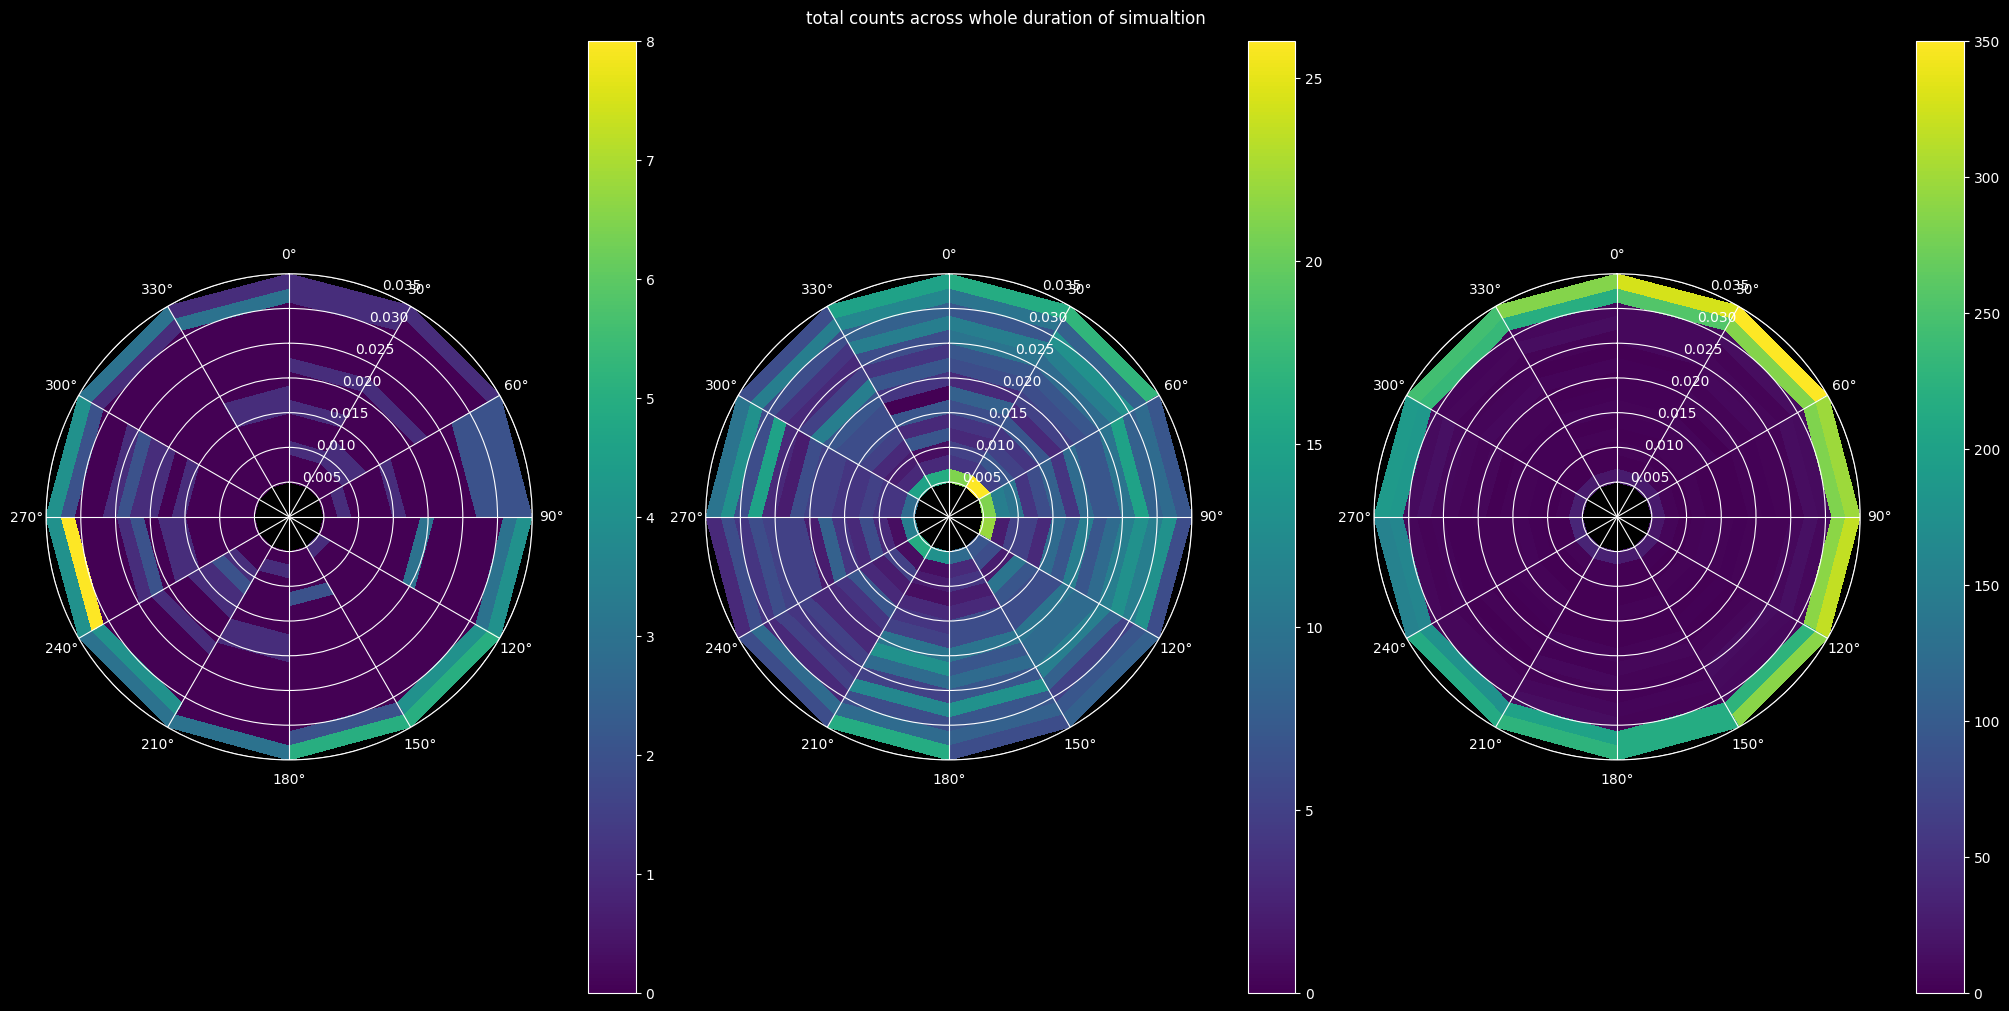

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

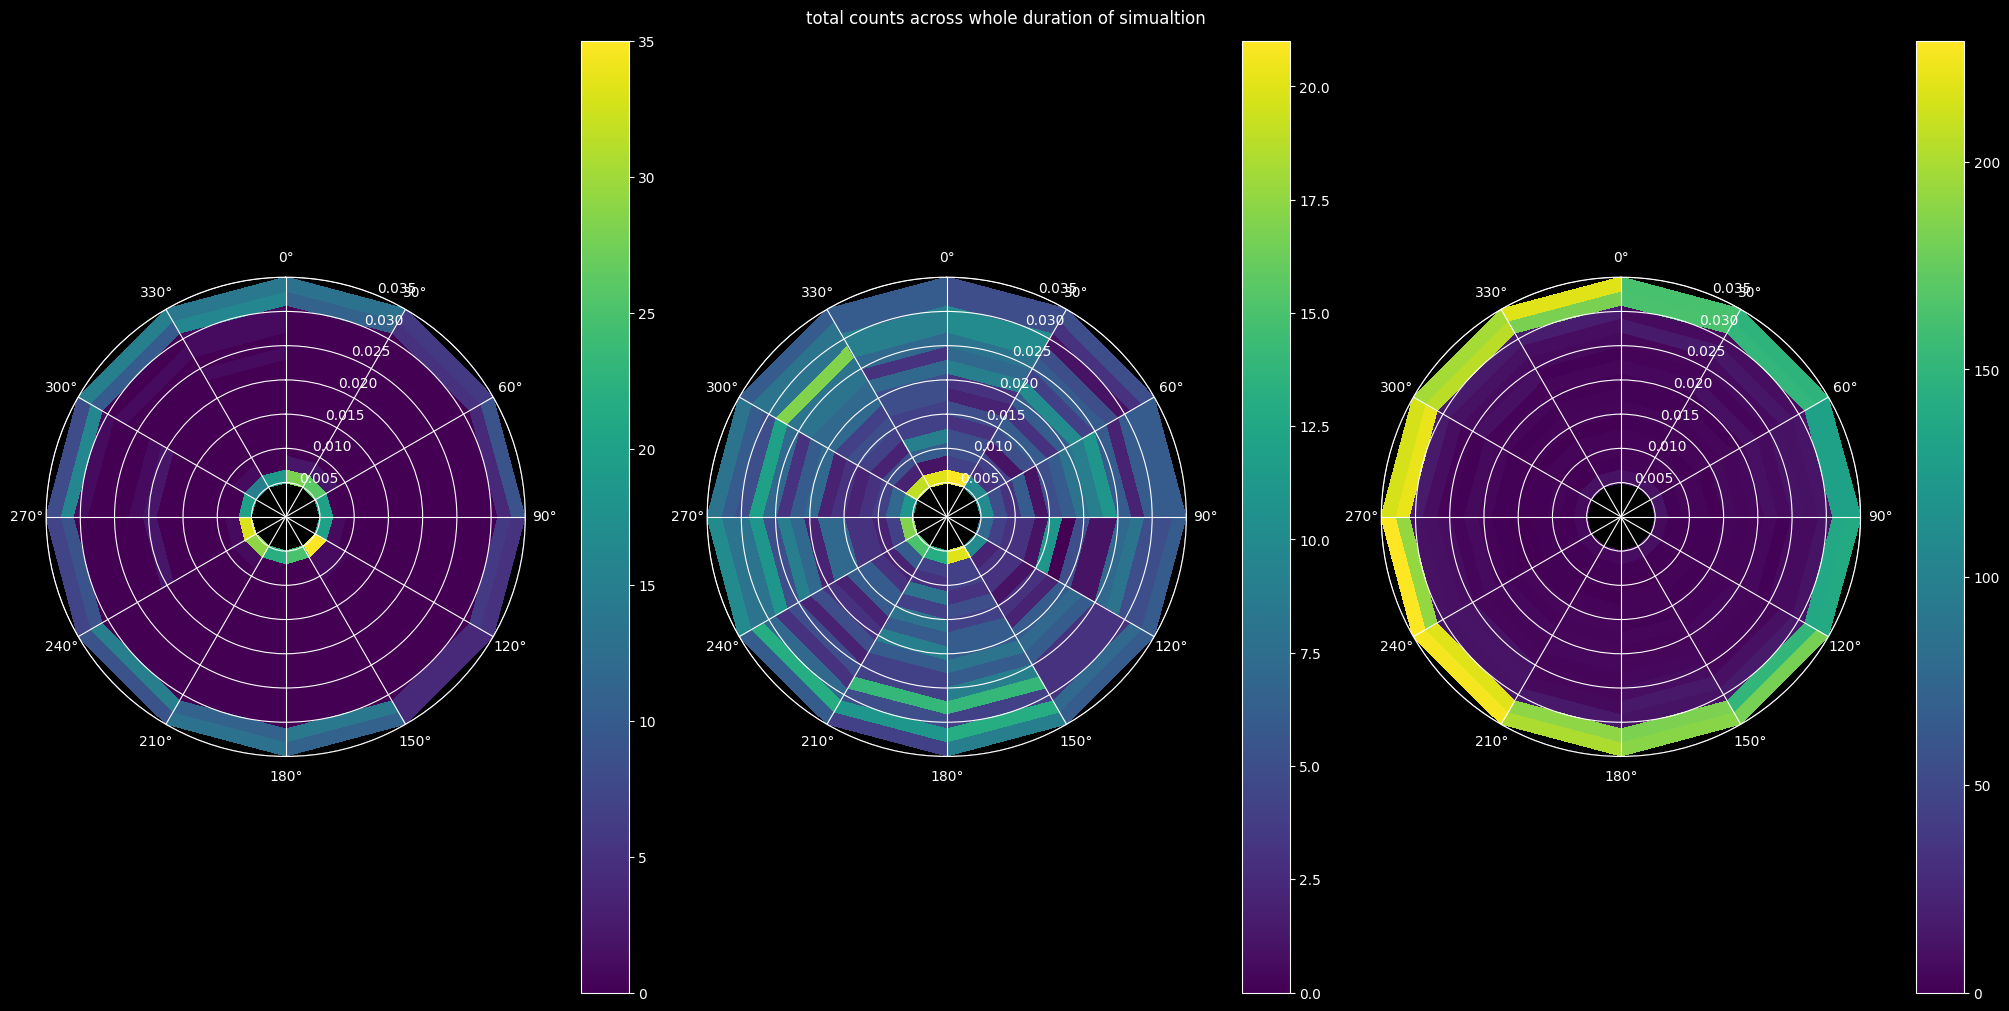

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

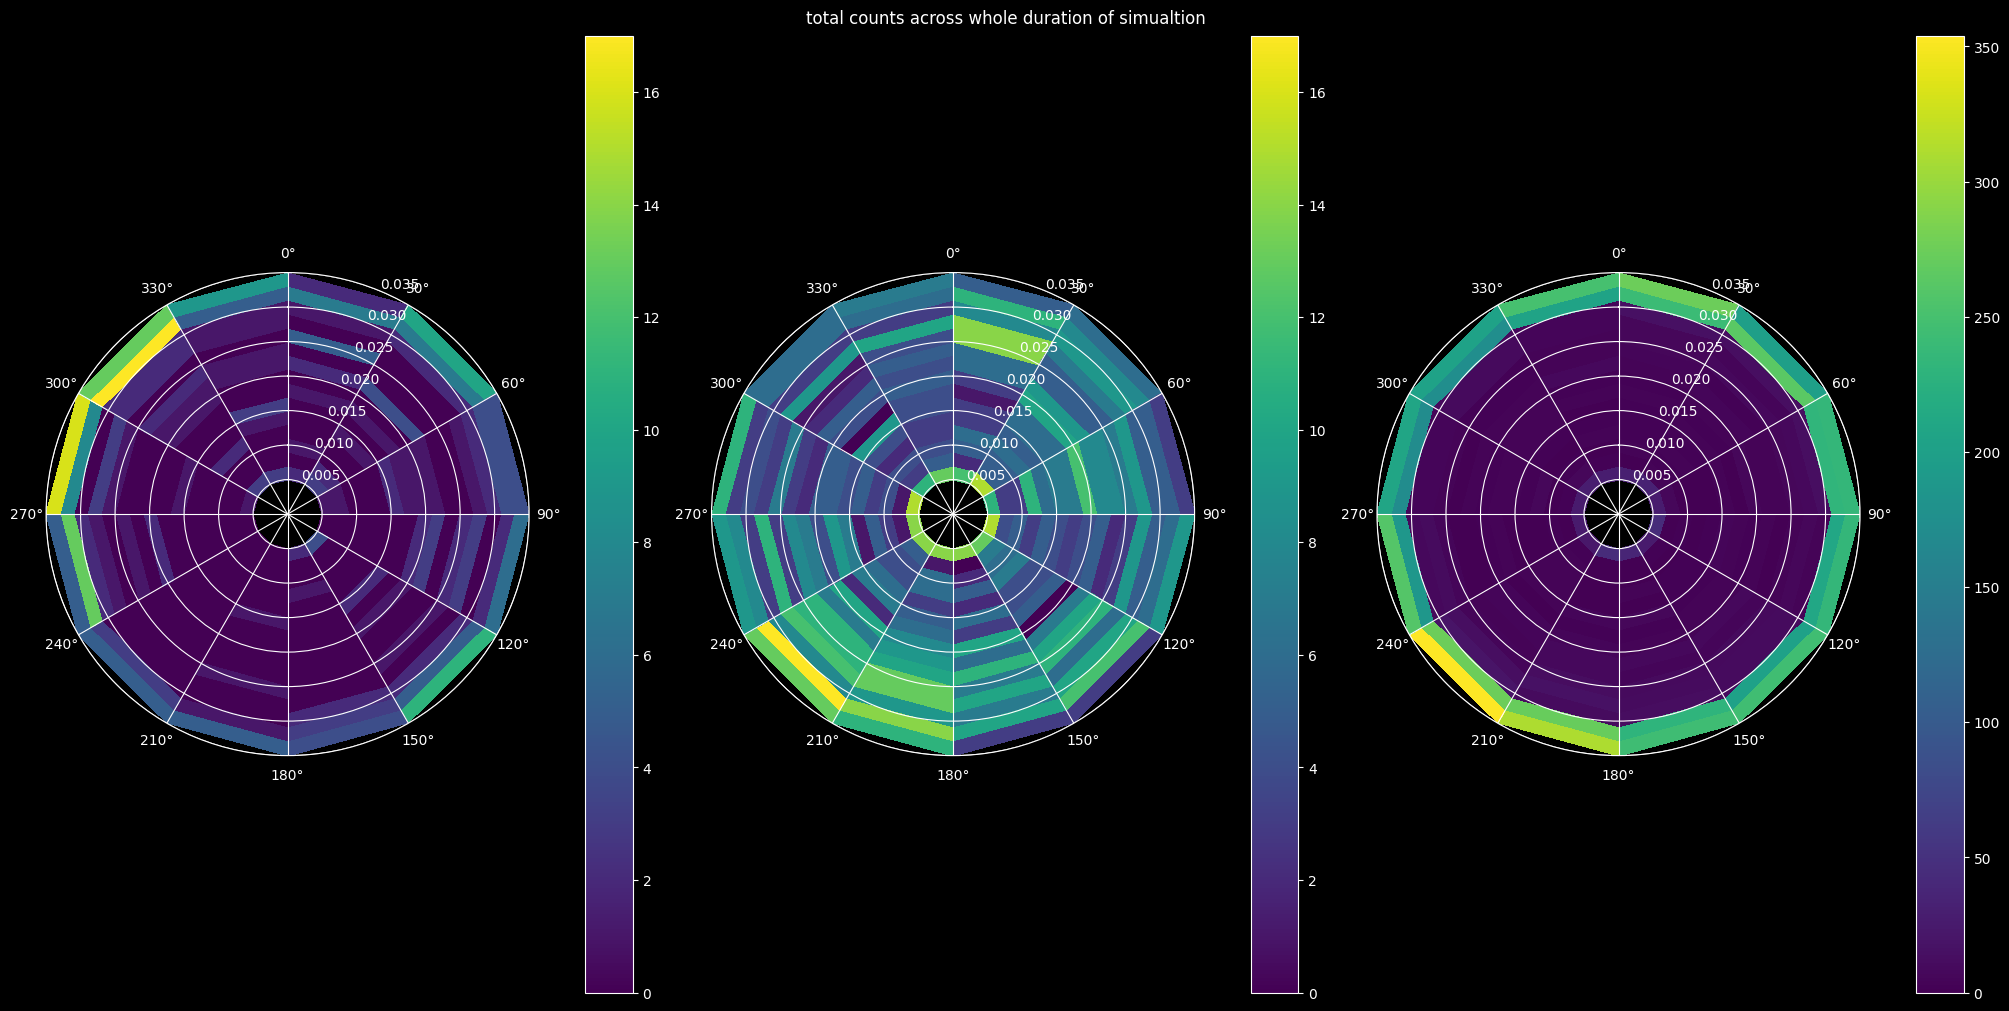

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [28]:
for param in ordered_list_of_parameters[::3]:
    fig, ax = plt.subplots(
                1,
                3,
                figsize=(20, 10),
                subplot_kw={"projection": "polar"},
                layout="constrained",
            )

    heard_sounds_array =dictionary_to_store_heard_sounds[param]
    grid_data = convert_into_grids(heard_sounds_array)
    spatial_grid_r = np.arange(0.005+RADIAL_RESOLUTION/2,0.035,RADIAL_RESOLUTION)
    spatial_grid_theta = np.arange(-np.pi+ANGULAR_RESOLUTION/2, np.pi, ANGULAR_RESOLUTION)
    plot_grid_matrix_into_radial(grid_data[0], spatial_grid_r, spatial_grid_theta, fig_and_ax=(fig,ax[0]))
    plot_grid_matrix_into_radial(grid_data[1], spatial_grid_r, spatial_grid_theta, fig_and_ax=(fig,ax[1]))
    plot_grid_matrix_into_radial(grid_data[2], spatial_grid_r, spatial_grid_theta, fig_and_ax=(fig,ax[2]))
    fig.suptitle("total counts across whole duration of simualtion")
    plt.show()